In [1]:
#Please install and run these packages
library(tidyverse)
library(readr)
library(tidymodels)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## 1. Data description

We are analyzing two linked datasets from a UBC Minecraft research server:

- **players.csv** (196 rows, 7 columns)  
  - `hashedEmail` (character): anonymized player ID; key linking files.  
  - `name` (character): first name; not used as a predictor.  
  - `gender` (categorical: Male, Female, Non-binary, Two-Spirited, Agender, Other, Prefer not to say).  
  - `Age` (numeric, years; 2 missing).  
  - `experience` (categorical: Beginner, Amateur, Regular, Veteran, Pro).  
  - `played_hours` (numeric): total hours of recorded gameplay.  
  - `subscribe` (logical): newsletter subscription.

- **sessions.csv** (1535 rows, 5 columns)  
  - `hashedEmail`: player ID, matches players.csv.  
  - `start_time`, `end_time` (character): session start/end (day/month/year hour:minute).  
  - `original_start_time`, `original_end_time` (numeric): timestamps (milliseconds since Unix epoch).

Main issues:

- Many players have **no matching session rows**, so they appear to have never started a logged session.  
- `played_hours` is almost the sum of session durations, so it is highly collinear with total server time.  
- A few sessions have missing end times, so their durations are unknown.  
- Activity is extremely skewed (most players have 0–1 sessions, a few have hundreds), giving heavy tails and outliers.  
- Demographic variables are self-reported in a convenience sample, so bias is possible.

## 2. Questions

- **Broad question (Q2):** Which kinds of players are most likely to generate large amounts of gameplay data on the server?  
- **Specific predictive question:** *Can basic player characteristics (age, gender, experience level, newsletter subscription) predict whether a player becomes a “high-activity” user who produces many sessions on the server?*

I will define **HighActivity** = 1 if a player has at least 2 logged sessions (upper quartile), and 0 otherwise. Explanatory variables come from players.csv. sessions.csv is used only to count sessions.

## 3. Exploratory analysis plan

I will:

- Load both CSVs, join by `hashedEmail`, and compute per-player summaries: number of sessions and total minutes played.  
- Tidy to one row per player, replacing missing session counts with 0.  
- Compute means for quantitative variables in players.csv (`Age`, `played_hours`) and report them in a table.  
- Create plots: histogram of session counts; boxplots of session counts by experience and gender; scatterplot of age versus session count.  
- Use these to see which groups appear more active and to check skewness, outliers, and missingness.

In [12]:
players_url  <- "https://raw.githubusercontent.com/Elijah-Lal/Individual-Project-Planning-Stage/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/Elijah-Lal/Individual-Project-Planning-Stage/refs/heads/main/sessions.csv"

download.file(players_url,  destfile = "data/players.csv", mode = "wb")
download.file(sessions_url, destfile = "data/sessions.csv", mode = "wb")

players  <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Next, I create a per-player summary using the `sessions.csv` file. For each player, I count how many sessions they have. I then join this information back to the player-level data in `players.csv`. Players who never appear in `sessions.csv` are assumed to have 0 sessions.

Using the session counts, I define a binary variable `HighActivity`, which equals `TRUE` if a player has at least 2 sessions, and `FALSE` otherwise. This variable represents whether a player contributes more than a minimal amount of gameplay data.

In [16]:
per_player <- sessions |>
  group_by(hashedEmail) |>
  summarise(
    n_sessions = n(),
    .groups = "drop"
  )

players_joined <- players |>
  left_join(per_player, by = "hashedEmail") |>
  mutate( n_sessions   = replace_na(n_sessions, 0),
         HighActivity = n_sessions >= 2)

glimpse(players_joined)

Rows: 196
Columns: 9
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
$ n_sessions   <int> 27, 3, 1, 1, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 0, 0, 0, 37, 2…
$ HighActivity <lgl> TRUE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…


For a more detailed measure of activity, we can also compute the total minutes played for each player using the numeric start and end timestamps in `sessions.csv`.


In [17]:
sessions_with_duration <- sessions |>
  mutate(
    duration_min = (original_end_time - original_start_time) / 1000 / 60
  )

# Summarising both session counts and total minutes per player
per_player_detailed <- sessions_with_duration |>
  group_by(hashedEmail) |>
  summarise(
    n_sessions    = n(),
    total_minutes = sum(duration_min, na.rm = TRUE),
    .groups = "drop"
  )

# Joining back to players data and handle missing values
players_joined <- players |>
  left_join(per_player_detailed, by = "hashedEmail") |>
  mutate(
    n_sessions    = replace_na(n_sessions, 0),
    total_minutes = replace_na(total_minutes, 0),
    HighActivity  = n_sessions >= 2
  )

glimpse(players_joined)

Rows: 196
Columns: 10
$ experience    <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amat…
$ subscribe     <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, …
$ hashedEmail   <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f…
$ played_hours  <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, …
$ name          <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adria…
$ gender        <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fem…
$ Age           <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 1…
$ n_sessions    <int> 27, 3, 1, 1, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 0, 0, 0, 37, …
$ total_minutes <dbl> 2000.0000, 166.6667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0…
$ HighActivity  <lgl> TRUE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FA…


I am now summarising the structure of the joined player dataset and examining the distributions of key categorical variables. Then, I compute the mean of each numeric variable in `players.csv` (such as `Age` and `played_hours`), rounding the results to two decimal places as required.

In [19]:
# Basic information on rows and columns
nrow(players_joined)
ncol(players_joined)

# Categorical summaries for experience, gender, and subscription status
players_joined |>
  count(experience)

players_joined |>
  count(gender)

players_joined |>
  count(subscribe)

# Mean of each numeric variable in players.csv
players_means <- players |>
  summarise(across(where(is.numeric), ~ mean(.x, na.rm = TRUE))) |>
  pivot_longer(
    everything(),
    names_to = "variable",
    values_to = "mean"
  ) |>
  mutate(mean = round(mean, 2))

players_means

experience,n
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


gender,n
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,144


variable,mean
<chr>,<dbl>
played_hours,5.85
Age,21.14


First, I'll look at the overall distribution of the number of sessions per player. This helps reveal how skewed player activity is and whether a small number of players contribute a disproportionately large number of sessions.

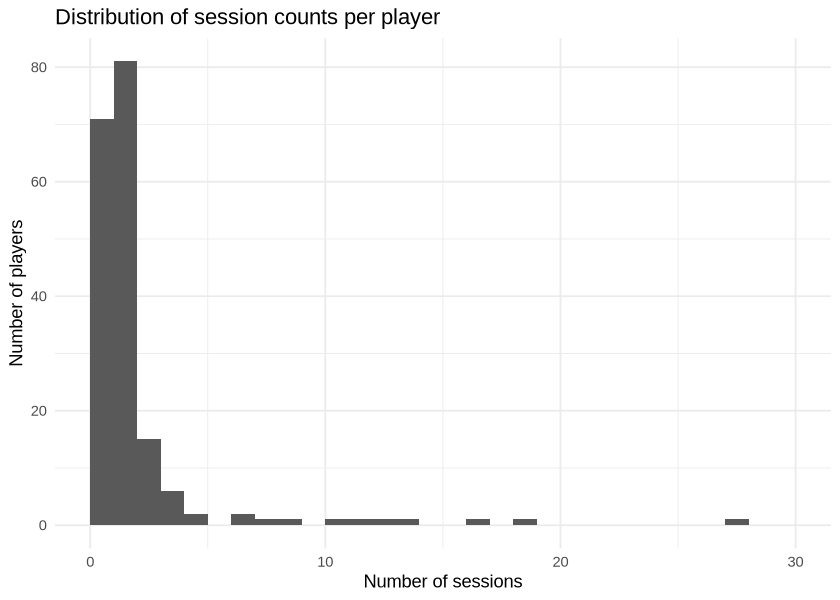

In [20]:
options(repr.plot.width = 7, repr.plot.height = 5)

ggplot(players_joined, aes(x = n_sessions)) +
  geom_histogram(binwidth = 1, boundary = 0, closed = "left") +
  coord_cartesian(xlim = c(0, 30)) +  # focus on players with up to 30 sessions
  labs(
    title = "Distribution of session counts per player",
    x = "Number of sessions",
    y = "Number of players"
  ) +
  theme_minimal()

Next, I'll compare the number of sessions across different self-reported experience levels. This can reveal whether more experienced players tend to be more active on the server.

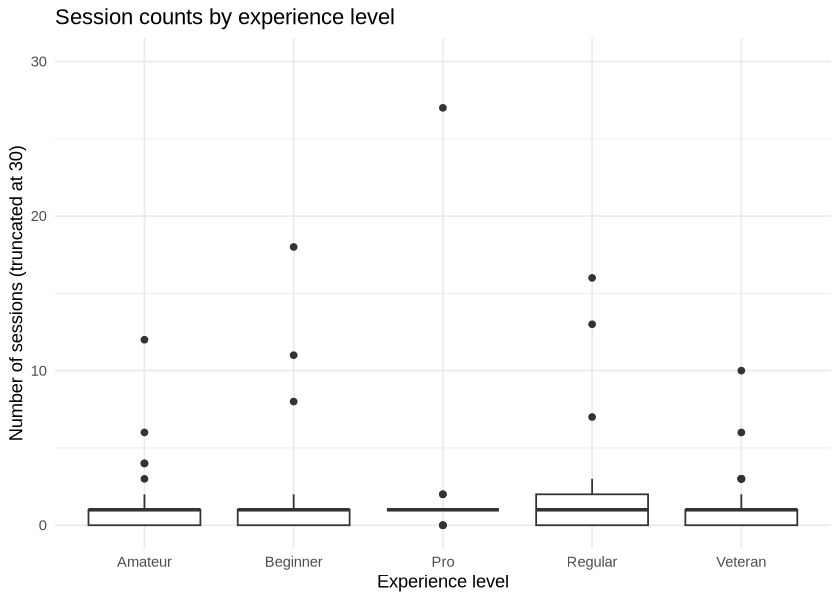

In [21]:
ggplot(players_joined, aes(x = experience, y = n_sessions)) +
  geom_boxplot() +
  coord_cartesian(ylim = c(0, 30)) +
  labs(
    title = "Session counts by experience level",
    x = "Experience level",
    y = "Number of sessions (truncated at 30)"
  ) +
  theme_minimal()

I'll also examine session counts by gender identity to see if there are any visible differences in activity patterns across demographic groups. This is exploratory only and should be interpreted with caution due to sample size and potential biases.


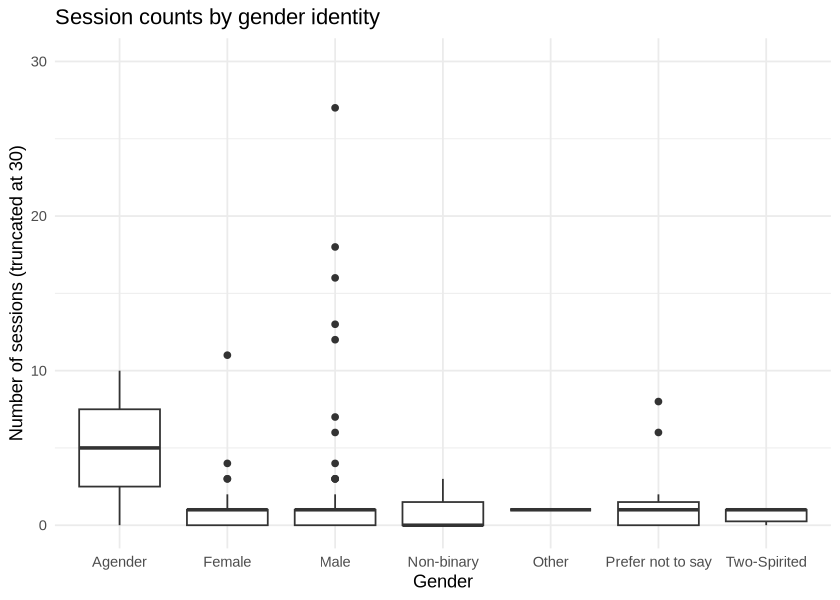

In [22]:
ggplot(players_joined, aes(x = gender, y = n_sessions)) +
  geom_boxplot() +
  coord_cartesian(ylim = c(0, 30)) +
  labs(
    title = "Session counts by gender identity",
    x = "Gender",
    y = "Number of sessions (truncated at 30)"
  ) +
  theme_minimal()

Finally, I can explore the relationship between age and activity by plotting the number of sessions against player age. This helps identify whether age appears related to how often players log in.


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


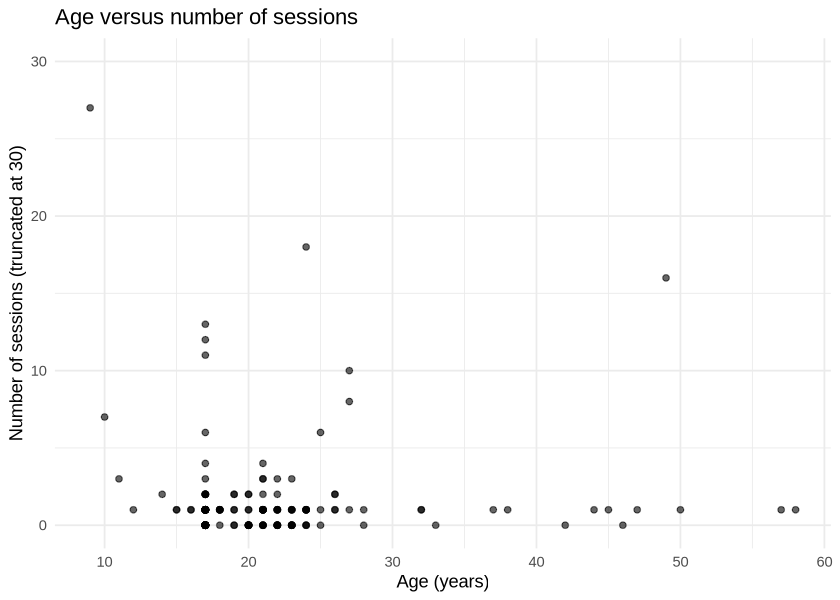

In [23]:
ggplot(players_joined, aes(x = Age, y = n_sessions)) +
  geom_point(alpha = 0.6) +
  coord_cartesian(ylim = c(0, 30)) +
  labs(
    title = "Age versus number of sessions",
    x = "Age (years)",
    y = "Number of sessions (truncated at 30)"
  ) +
  theme_minimal()